In [1]:
import copy
import shutil
import math
import os
import time
import textwrap

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchinfo

import utility as util
from helpers import imagenet_idx_to_label

def show_image(ax, image):
    image = image / 2 + 0.5
    ax.imshow(image.numpy().transpose(1,2,0))

Create (train, test) set from dataset

In [2]:
def split_files(datadir, splitdir, classes, frac_train=0.8):
    traindir = os.path.join(splitdir, 'train')
    os.makedirs(traindir, exist_ok=True)
    testdir  = os.path.join(splitdir, 'test')
    os.makedirs(testdir,  exist_ok=True)
    
    for _class in tqdm(classes):
        classdir = os.path.join(datadir, _class)
        files    = os.listdir(classdir)
        n_train  = int(frac_train*len(files))
        trainfiles = files[:n_train]
        testfiles  = files[n_train:]
        
        for datatype, _dir, files in [('train', traindir, trainfiles), ('test', testdir, testfiles)]:
            for file in files:
                srcfile = os.path.join(classdir, file)
                dstdir = os.path.join(_dir, _class)
                os.makedirs(dstdir, exist_ok=True)
                shutil.move(srcfile, dstdir)
        
# print(os.listdir('data/caltech101/101_ObjectCategories'))
classes = ['butterfly', 'mandolin', 'mayfly', 'watch', 'inline_skate', 'ibis', 'helicopter', 'brontosaurus',
          'hawksbill', 'garfield', 'stop_sign', 'menorah', 'binocular', 'cougar_body', 'anchor', 'Faces_easy',
          'bass', 'ketch', 'car_side', 'pizza', 'ewer', 'scissors', 'lamp', 'ceiling_fan', 'wheelchair', 'platypus',
          'lobster', 'wild_cat', 'crayfish', 'camera', 'dolphin', 'windsor_chair', 'saxophone', 'revolver',
          'crocodile', 'kangaroo', 'pyramid', 'llama', 'cannon', 'octopus', 'schooner', 'pagoda', 'strawberry',
          'flamingo_head', 'crocodile_head', 'rhino', 'sea_horse', 'chair', 'beaver',
          'starfish', 'umbrella', 'buddha', 'gerenuk', 'bonsai', 'metronome', 'pigeon', 'cellphone',
          'stegosaurus', 'elephant', 'grand_piano', 'tick', 'lotus', 'euphonium', 'chandelier', 'soccer_ball',
          'cup', 'headphone', 'crab', 'joshua_tree', 'minaret', 'ferry', 'nautilus', 'electric_guitar', 'wrench',
          'Leopards', 'rooster', 'flamingo', 'dalmatian', 'stapler', 'yin_yang', 'water_lilly', 'ant', 'barrel',
          'gramophone', 'airplanes', 'snoopy', 'sunflower', 'accordion', 'cougar_face', 'scorpion', 'okapi',
          'laptop', 'panda', 'hedgehog', 'Motorbikes', 'dollar_bill', 'dragonfly', 'trilobite', 'emu', 'brain']
split_files('../data/caltech101/101_ObjectCategories', '../data/caltech101', classes)

  0%|          | 0/100 [00:00<?, ?it/s]

Set up data transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class SquarePad:
    """
    Based on:
    https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/3
    """
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')

image_transforms = {
    'train': transforms.Compose([
            SquarePad(),
            transforms.RandomRotation(degrees=10),
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=100, scale=(0.95,1.05), ratio=(0.95, 1.05)),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)
    ]),
    'test': transforms.Compose([
            SquarePad(),
            transforms.Resize(100),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)              
    ])
}

Using device: cuda:0


In [4]:
folder = torchvision.datasets.ImageFolder(root='../data/caltech101/test')
folder[0]

(<PIL.Image.Image image mode=RGB size=263x332 at 0x7F288EFB5FD0>, 0)

Get dataset

In [18]:
data = {
    'train': torchvision.datasets.ImageFolder(root='../data/caltech101/train', transform=image_transforms['train']),
    'test': torchvision.datasets.ImageFolder(root='../data/caltech101/test', transform=image_transforms['test'])
}
## dataset attributes
# data['train'].targets # the labels of the dataset
classes = data['train'].classes # class names
# data['train'].class_to_idx # mapping of class name to index
assert data['train'].classes == data['test'].classes
print(f"{len(data['train'])} training samples; {len(data['test'])} testing samples")

6559 training samples; 1683 testing samples


View train set

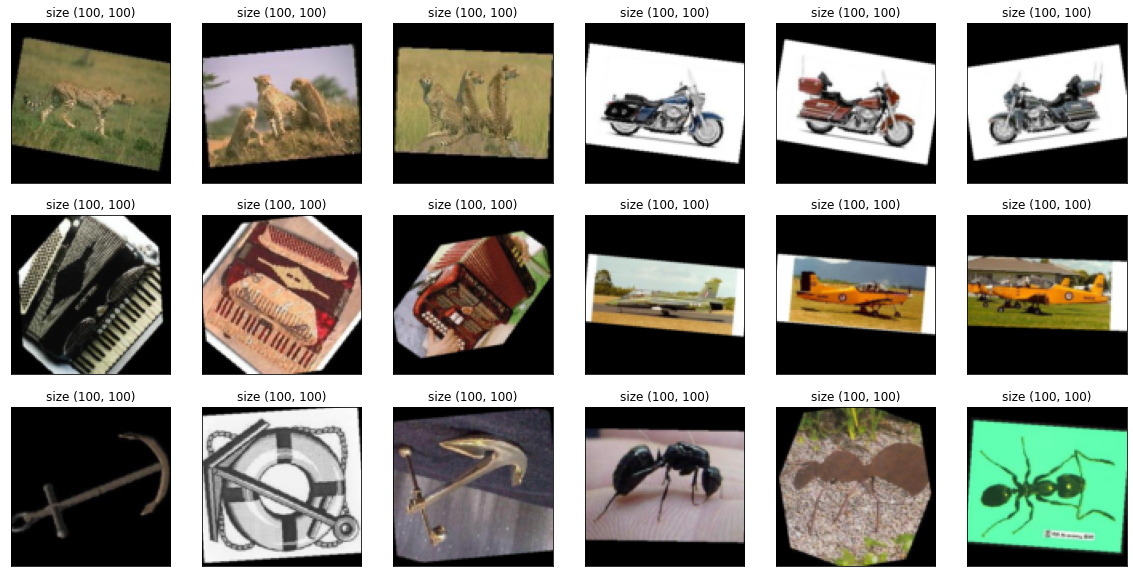

In [6]:
labels = [1, 2, 3, 4, 5, 6]#, 7, 8, 9, 10]
n_images = 3
n_labels = len(labels)
n_plots = n_labels*n_images
fig, axes = plt.subplots(n_plots // 6 + int(n_plots % 6 > 0), 6, figsize=(20, 10))
axes = axes.ravel()
idx = 0

for label in labels:
    samples = util.filter_to_sublist(lambda x: x[1] == label, data['train'], n_images)
    for s_idx, (image, label) in enumerate(samples):
        show_image(axes[idx], image)
        _, w, h = image.shape
        axes[idx].set_title(f"size ({w}, {h})")
        idx += 1

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

View test set

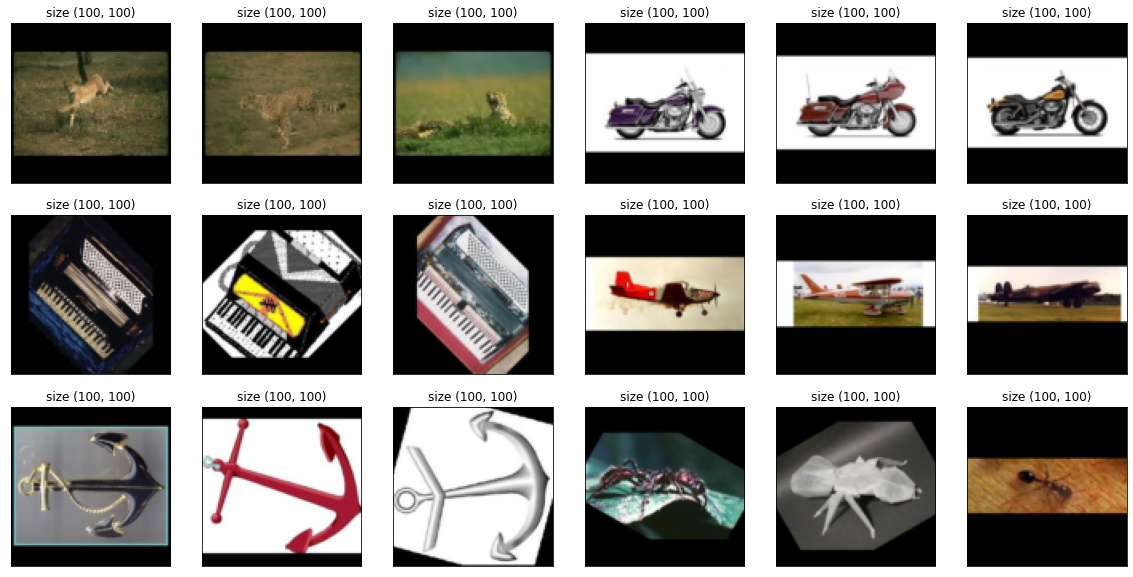

In [7]:
labels = [1, 2, 3, 4, 5, 6]#, 7, 8, 9, 10]
n_images = 3
n_labels = len(labels)
n_plots = n_labels*n_images
fig, axes = plt.subplots(n_plots // 6 + int(n_plots % 6 > 0), 6, figsize=(20, 10))
axes = axes.ravel()
idx = 0

for label in labels:
    samples = util.filter_to_sublist(lambda x: x[1] == label, data['test'], n_images)
    for s_idx, (image, label) in enumerate(samples):
        show_image(axes[idx], image)
        _, w, h = image.shape
        axes[idx].set_title(f"size ({w}, {h})")
        idx += 1

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

Get histogram of the classes

Here's the specs for sets


(100,
 array([ 24,  25,  26,  27,  27,  27,  27,  28,  28,  28,  29,  30,  31,
         31,  31,  32,  32,  32,  33,  33,  33,  34,  34,  34,  36,  36,
         36,  36,  37,  37,  37,  37,  39,  39,  40,  40,  40,  40,  41,
         42,  42,  43,  43,  44,  44,  44,  45,  45,  45,  47,  47,  47,
         47,  48,  48,  49,  50,  51,  51,  51,  51,  51,  52,  52,  53,
         53,  53,  54,  55,  56,  58,  60,  60,  60,  62,  64,  64,  65,
         67,  68,  68,  68,  68,  68,  68,  69,  70,  72,  78,  79,  80,
         85,  91,  98, 102, 160, 191, 348, 638, 640]))

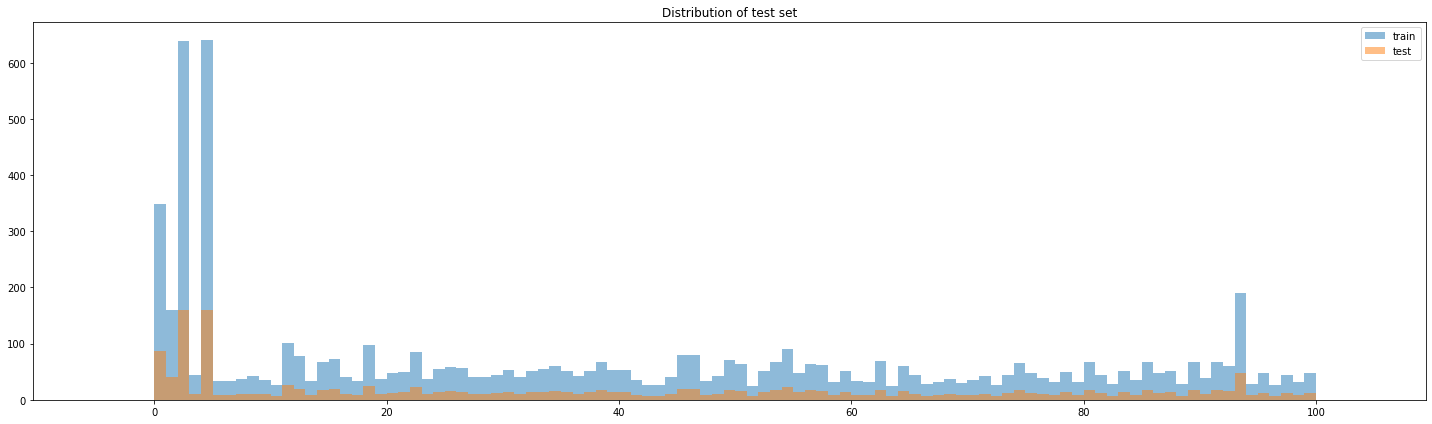

In [8]:
_data = {
    'train': torchvision.datasets.ImageFolder(root='../data/caltech101/train', transform=transforms.ToTensor()),
    'test': torchvision.datasets.ImageFolder(root='../data/caltech101/test', transform=transforms.ToTensor())
}

fig, ax = plt.subplots(1, 1, figsize=(20,6))
axes = [ax]

labels = _data['train'].targets
bins = range(-5,105)
axes[0].hist(labels, bins=bins, alpha=0.5, label='train')
labels = _data['test'].targets
axes[0].hist(labels, bins=bins, alpha=0.5, label='test')
axes[0].set_title("Distribution of test set")
axes[0].legend(loc='upper right')
fig.tight_layout()

labels = _data['train'].targets
counts = np.bincount(labels)
print("Here's the specs for sets")
counts.sort()
counts.size, counts # should show that many samples have ~ 

Set up data sampler and dataloader

In [9]:
args = util.AttrDict(epochs=5, print_every=50, batch_size=32,
        learning_rate=0.01, output_size=100)

In [10]:
def get_sampler(labels, n_samples=None, replacement=True):
    """Computes the weights for the weighted random sampler based on label distribution
    
    Based on:
    https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264/25
    """
    _, counts = np.unique(labels, return_counts=True)
    weights = 1.0 / torch.tensor(counts, dtype=torch.float)
    sample_weights = weights[labels]
    if not n_samples:
        n_samples = len(sample_weights)
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, n_samples, replacement=True)
    return sampler

trainloader = torch.utils.data.DataLoader(data['train'],
        sampler=get_sampler(data['train'].targets, n_samples=8000),
        batch_size=args.batch_size, num_workers=2)
testloader = torch.utils.data.DataLoader(data['test'],
        sampler=get_sampler(data['test'].targets, n_samples=200, replacement=False),
        batch_size=args.batch_size, num_workers=2)

print(f"Training set: {len(trainloader)} batches, {len(trainloader) * args.batch_size} samples")
print(f"Test set: {len(testloader)} batches, {len(testloader) * args.batch_size} samples")

Training set: 250 batches, 8000 samples
Test set: 7 batches, 224 samples


stapler dolphin  ewer mayfly lobster stegosaurus car_side kangaroo pigeon brain pizza lobster stapler mayfly sunflower metronome water_lilly beaver gramophone  tick wheelchair flamingo gramophone umbrella nautilus mayfly camera kangaroo cellphone car_side cannon   ant


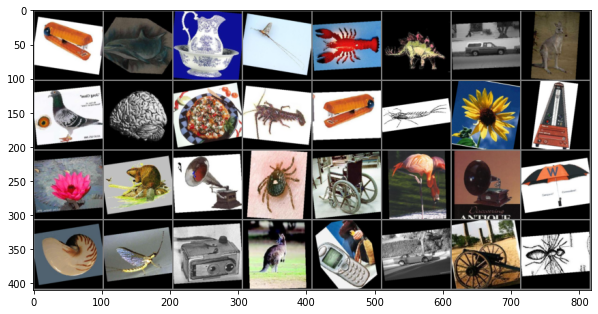

In [11]:
# functions to show an image
def imshow(img):
    # Un-normalize data.
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
# images has shape (batch size, num channels (3), hor width, ver height)
# labels has shape (batch size,)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(10, 10))
show_image(plt.gca(), torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % data['train'].classes[labels[j]] for j in range(args.batch_size)))

In [12]:
mobilenet = torchvision.models.mobilenet_v3_large(pretrained=True, progress=True)
mobilenet = mobilenet.to(device)

In [13]:
col_names = ("input_size", "output_size", "num_params", "kernel_size")#, "mult_adds",)
torchinfo.summary(mobilenet, input_size=(1, 3, 32, 32), col_names=col_names, col_width=18)

Layer (type:depth-idx)                        Input Shape        Output Shape       Param #            Kernel Shape
MobileNetV3                                   --                 --                 --                 --
├─Sequential: 1-1                             [1, 3, 32, 32]     [1, 960, 1, 1]     --                 --
│    └─ConvBNActivation: 2-1                  [1, 3, 32, 32]     [1, 16, 16, 16]    --                 --
│    │    └─Conv2d: 3-1                       [1, 3, 32, 32]     [1, 16, 16, 16]    432                [3, 16, 3, 3]
│    │    └─BatchNorm2d: 3-2                  [1, 16, 16, 16]    [1, 16, 16, 16]    32                 [16]
│    │    └─Hardswish: 3-3                    [1, 16, 16, 16]    [1, 16, 16, 16]    --                 --
│    └─InvertedResidual: 2-2                  [1, 16, 16, 16]    [1, 16, 16, 16]    --                 --
│    │    └─Sequential: 3-4                   [1, 16, 16, 16]    [1, 16, 16, 16]    464                --
│    └─InvertedResidual

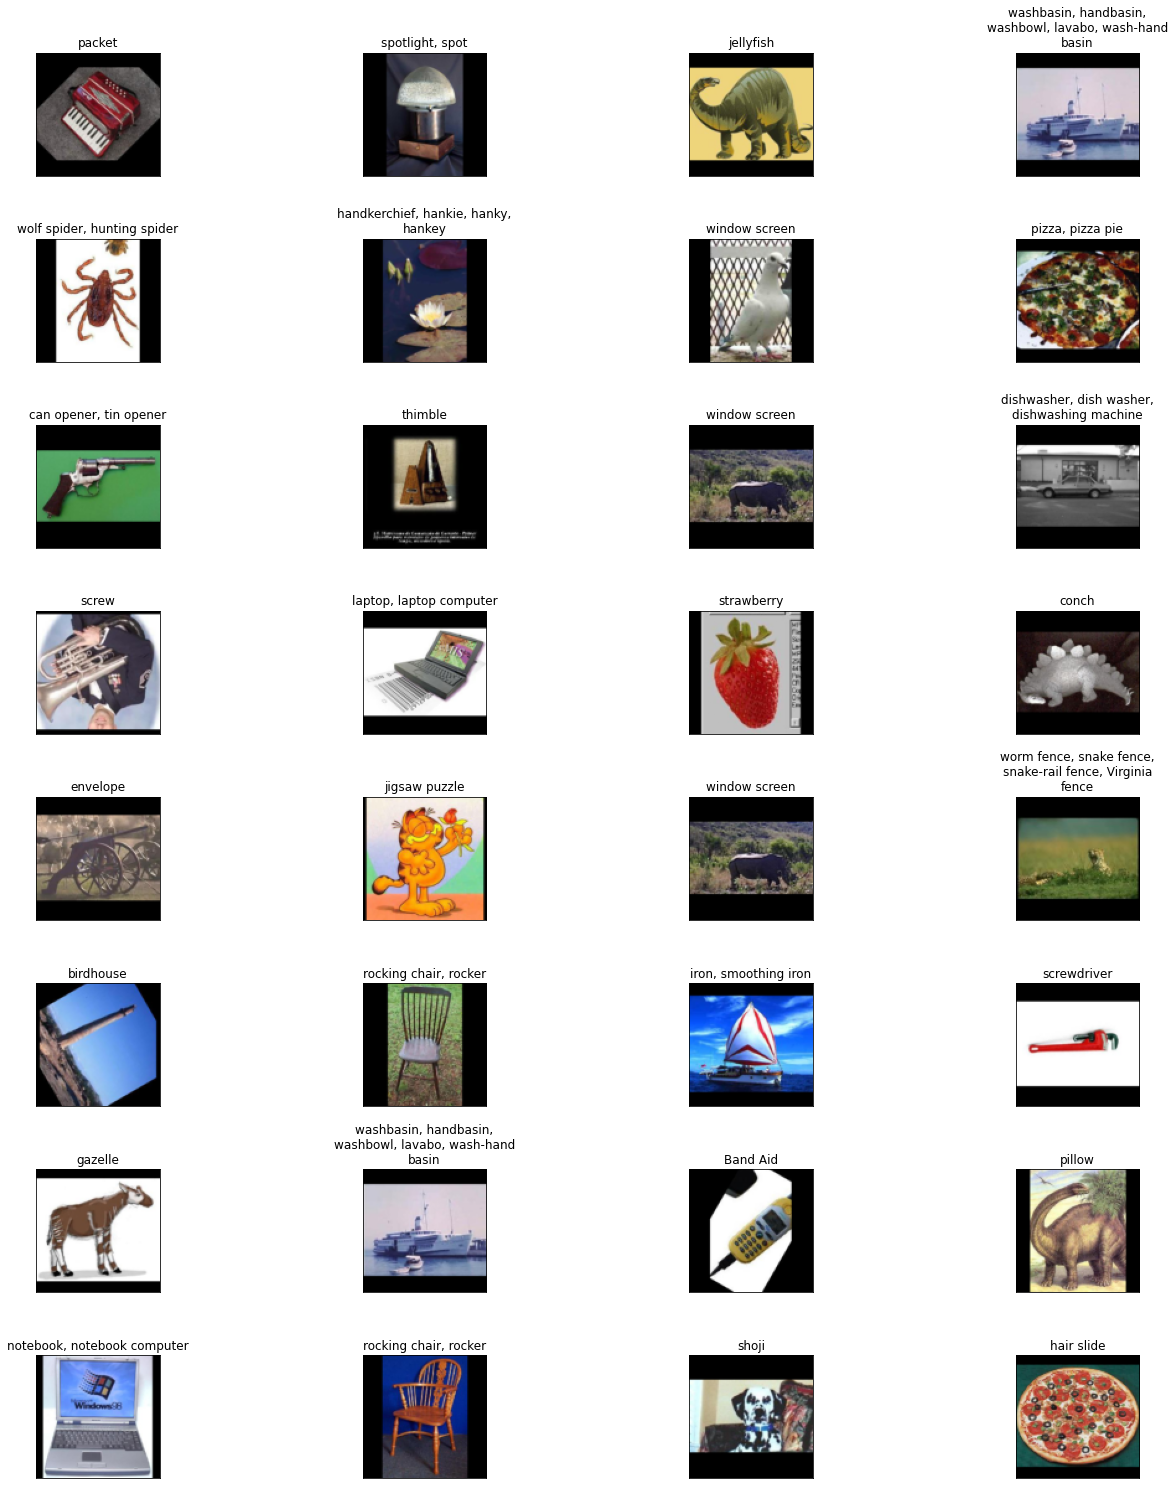

In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# select one image, unsqueezing axis 0 to make input batch of one image
_images = images.to(device)
# must set eval model for batch of one image, or model crashes
mobilenet.eval()
with torch.no_grad():
    outputs = mobilenet(_images)
mobilenet.train()
# model ouptputs to imagenet labels
imagenet_idx_to_label
_, indices = outputs.max(1)
indices = indices.cpu().numpy()
labels = [imagenet_idx_to_label[i] for i in indices]
batchsize = images.shape[0]
fig, axes = plt.subplots(batchsize // 4, 4, figsize=(20, 20))
axes = axes.ravel()
for idx, ax in enumerate(axes):
    image = (images[idx].numpy() / 2 + 0.5).transpose(1, 2, 0)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    title = "\n".join(textwrap.wrap(labels[idx], 30))
    title = ax.set_title(title)
    title.set_y(1.1)
    
fig.tight_layout()
fig.subplots_adjust(top=1)

In [15]:
"""The original MobileNet V3 (small) classifier has this form
Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)
"""
mobilenet.classifier = nn.Sequential(*[
        nn.Linear(in_features=960, out_features=1280, bias=True),
        nn.Hardswish(),
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=args.output_size, bias=True),]).to(device)

Declare the model

In [16]:
loss_over_time = []
acc_over_time = []
def train(net, args, trainloader, testloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.learning_rate, momentum=0.9)
#     optimizer = optim.Adam(net.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
#     scheduler = None
    
    for epoch in range(1, args.epochs + 1):
        prefix = f"Training Epoch {epoch}: "
        pbar = tqdm(trainloader, desc=prefix, 
                dynamic_ncols=True, leave=True, position=0)
        
        for iteration, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if iteration % args.print_every == 0 or iteration == len(trainloader)-1:
                pbar.set_description("Training epoch {} (loss {:9.4f}): ".format(epoch, loss.item()))
                pbar.update()
                loss_over_time.append(loss.item())
        correct = 0
        total = 0
        with torch.no_grad():
            net.eval()
            prefix = f"Evaluating: "
            for inputs, labels in tqdm(testloader, desc=prefix,
                        dynamic_ncols=True, leave=True, position=0):
                inputs, labels = inputs.to(device), labels.to(device)
                # calculate outputs by running images through the network
                outputs = net(inputs)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            net.train()
        print("Test accuracy: {:1.2%}".format(correct / total))
        acc_over_time.append(correct / total)
        if scheduler:
            scheduler.step()
    print("Done.")

should_create_new_instance = True
if should_create_new_instance:
    start = time.time()
    train(mobilenet, args, trainloader, testloader)
    end = time.time()
    print(f"Training time took {end - start} seconds")
    torch.save(mobilenet.state_dict(), './models/caltech101_mobilenet.pth')
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    axes = axes.ravel()
    axes[0].plot(range(len(loss_over_time)), loss_over_time)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Training Iteration")
    axes[0].grid()
    axes[1].plot(range(len(acc_over_time)), acc_over_time)
    axes[1].set_ylabel("Test accuracy")
    axes[1].set_xlabel("Training Iteration")
    axes[1].grid()
else:
    mobilenet.load_state_dict(torch.load('./models/caltech101_mobilenet.pth'))

Training Epoch 1:   0%|                                                      | 0/250 [00:00<?, ?it/s]

Evaluating:   0%|                                                              | 0/7 [00:00<?, ?it/s]

Test accuracy: 70.00%


Training Epoch 2:   0%|                                                      | 0/250 [00:00<?, ?it/s]

Evaluating:   0%|                                                              | 0/7 [00:00<?, ?it/s]

Test accuracy: 76.00%


Training Epoch 3:   0%|                                                      | 0/250 [00:00<?, ?it/s]

Evaluating:   0%|                                                              | 0/7 [00:00<?, ?it/s]

Test accuracy: 81.00%


Training Epoch 4:   0%|                                                      | 0/250 [00:00<?, ?it/s]

Evaluating:   0%|                                                              | 0/7 [00:00<?, ?it/s]

Test accuracy: 82.50%


Training Epoch 5:   0%|                                                      | 0/250 [00:00<?, ?it/s]

Evaluating:   0%|                                                              | 0/7 [00:00<?, ?it/s]

Test accuracy: 82.50%
Done.
Training time took 65.28081464767456 seconds


NameError: name 'net' is not defined

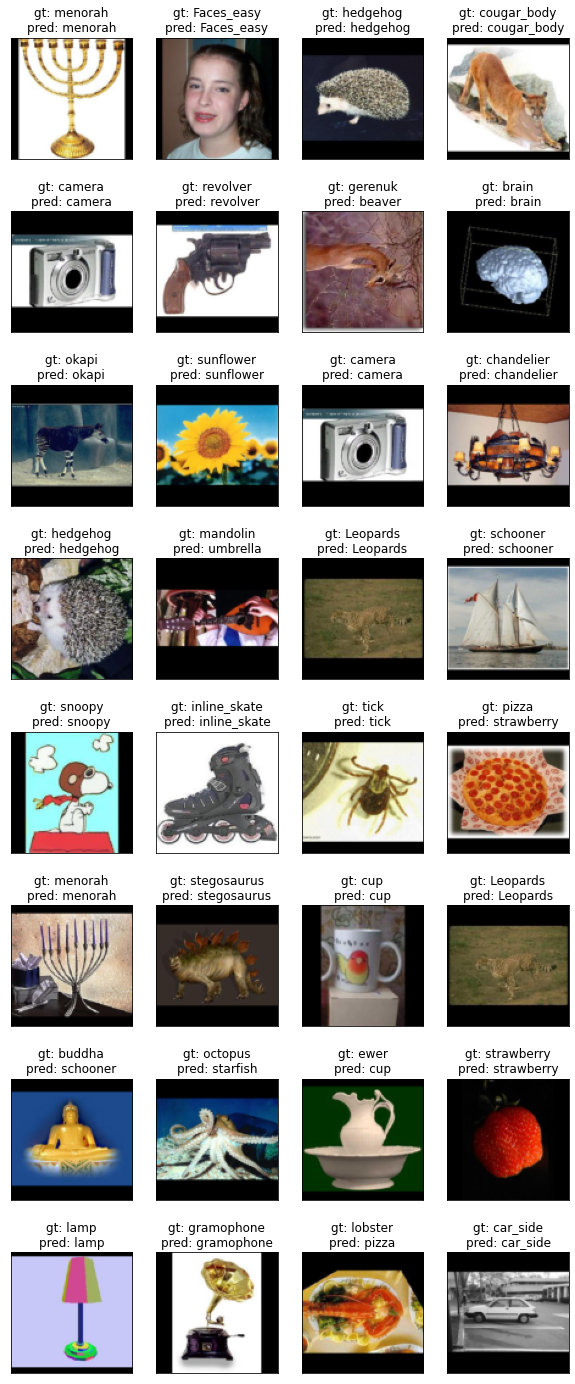

In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

_images = images.to(device)
mobilenet.eval()
with torch.no_grad():
    outputs = mobilenet(_images)
mobilenet.train()
_, predicted = torch.max(outputs, 1)

ground_truth = [classes[labels[j]] for j in range(args.batch_size)]
predictions = [classes[predicted[j]] for j in range(args.batch_size)]

df = pd.DataFrame({
    'GroundTruth': ground_truth,
    'Prediction': predictions
})

images = images.numpy()
n_rows = args.batch_size // 4 + int((args.batch_size % 4) > 0)
fig, axes = plt.subplots(n_rows, 4, figsize=(10, 25))
axes = axes.ravel()
for idx, image in enumerate(images):
    image = image / 2 + 0.5
    image = image.transpose((1, 2, 0))
    axes[idx].imshow(image)
    title = "gt: {}\npred: {}".format(df.at[idx, 'GroundTruth'], df.at[idx, 'Prediction'])
    axes[idx].set_title(title)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
mobilenet.eval()
with torch.no_grad():
    prefix = f"Evaluating: "
    for images, labels in tqdm(testloader, desc=prefix,
                dynamic_ncols=True, leave=True, position=0):
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = mobilenet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

mobilenet.train()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Evaluating:   0%|                                                              | 0/7 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


In [25]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
mobilenet.eval()
with torch.no_grad():
    mobilenet.eval()
    prefix = f"Evaluating: "
    for images, labels in tqdm(testloader, desc=prefix,
                dynamic_ncols=True, leave=True, position=0):
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
mobilenet.train()

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    try:
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
    except ZeroDivisionError:
        pass

Evaluating:   0%|                                                              | 0/7 [00:00<?, ?it/s]

Accuracy for class Faces_easy is: 100.0 %
Accuracy for class Leopards is: 100.0 %
Accuracy for class Motorbikes is: 100.0 %
Accuracy for class accordion is: 100.0 %
Accuracy for class airplanes is: 100.0 %
Accuracy for class anchor is: 25.0 %
Accuracy for class ant   is: 33.3 %
Accuracy for class barrel is: 100.0 %
Accuracy for class bass  is: 0.0 %
Accuracy for class beaver is: 100.0 %
Accuracy for class binocular is: 66.7 %
Accuracy for class bonsai is: 100.0 %
Accuracy for class brain is: 100.0 %
Accuracy for class buddha is: 100.0 %
Accuracy for class butterfly is: 100.0 %
Accuracy for class camera is: 100.0 %
Accuracy for class cannon is: 33.3 %
Accuracy for class car_side is: 100.0 %
Accuracy for class ceiling_fan is: 100.0 %
Accuracy for class cellphone is: 100.0 %
Accuracy for class chandelier is: 100.0 %
Accuracy for class cougar_face is: 50.0 %
Accuracy for class crab  is: 100.0 %
Accuracy for class crayfish is: 100.0 %
Accuracy for class crocodile is: 100.0 %
Accuracy for cl